# Bounding boxes for NWPU dataset

**Tasks**
- Check out data and preprocess
- Create largest object classifier
- Create largest BB classifier (might be crappy)

In [1]:
%matplotlib inline

In [110]:
from pathlib import Path
import json
from collections import defaultdict
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
from fastai.conv_learner import *
from fastai.dataset import *
import tqdm
from matplotlib import patches, patheffects

In [4]:
PATH = Path('/local/S.Rasp/NWPW-VHR-10')
!ls $PATH

ground-truth  negative-image-set  positive-image-set  readme.txt


## Check out data

### Plot some images

In [88]:
IMG_PATH = (PATH/'positive-image-set')

In [90]:
img_fns = [str(i).zfill(3) + '.jpg' for i in range(1, 651)]

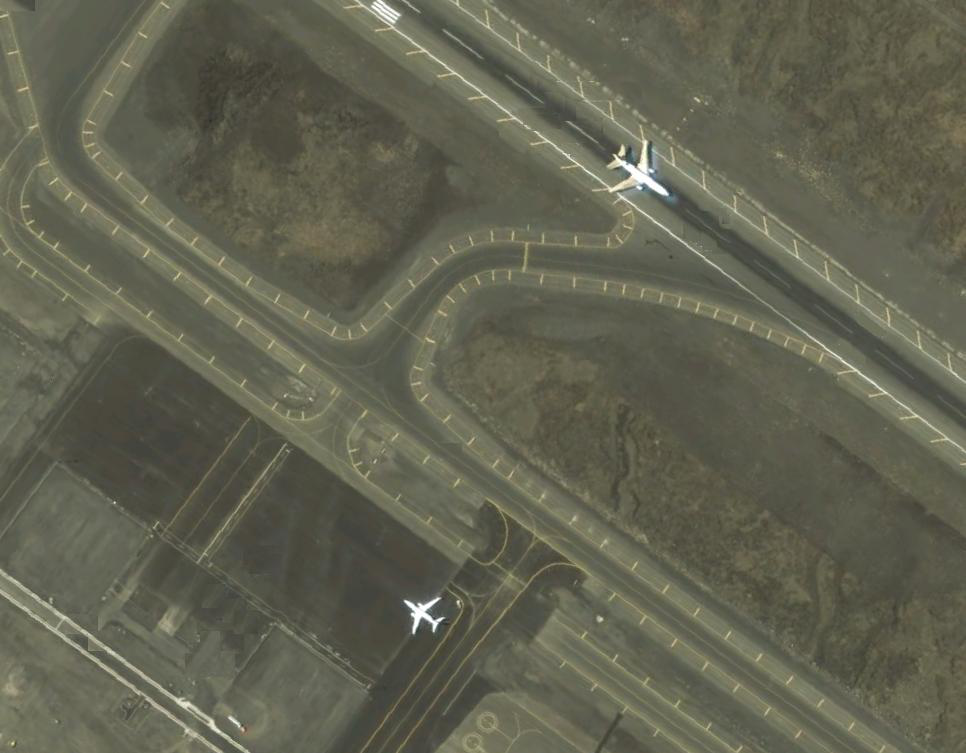

In [92]:
Image.open(IMG_PATH / img_fns[4])

### Read in bounding box data

In [119]:
for l in (PATH/'ground-truth/003.txt').open():
    print(l)

(100,256),(170,319),1 

(575,139),(668,240),1 

(753,382),(843,484),1 

(313,648),(415,764),1 

(434,674),(527,787),1 



In [72]:
cols = ['bb1', 'bb2', 'bb3', 'bb4', 'class']

In [78]:
df = pd.read_csv(PATH/'ground-truth/002.txt', sep=',', header=None, names=cols)

In [79]:
df.head()

bb1   bb2   bb3   bb4  class
0  (575  114)  (635  162)      1
1  ( 72  305)  (133  369)      1
2  (210  317)  (273  384)      1
3  (306  374)  (344  420)      1
4  (447  531)  (535  632)      1

In [80]:
df.dtypes

bb1      object
bb2      object
bb3      object
bb4      object
class     int64
dtype: object

In [83]:
for c in cols[:-1]: 
    df[c] = df[c].str.replace('(', '')
    df[c] = df[c].str.replace(')', '')
    df[c] = df[c].astype(int)

In [84]:
df

bb1  bb2  bb3  bb4  class
0  575  114  635  162      1
1   72  305  133  369      1
2  210  317  273  384      1
3  306  374  344  420      1
4  447  531  535  632      1
5  546  605  625  707      1
6  632  680  720  790      1

In [101]:
np.array(df.iloc[0, :4])

array([575, 114, 635, 162])

In [120]:
bbs = defaultdict(list)
for i in range(1, 651):
    df = pd.read_csv(PATH/f'ground-truth/{str(i).zfill(3)}.txt', sep=',', header=None, names=cols)
    for c in cols[:-1]: 
        df[c] = df[c].str.replace('(', '')
        df[c] = df[c].str.replace(')', '')
        df[c] = df[c].astype(int)
    for idx in df.index:
        bb = np.array(df.iloc[idx, :4])
        cls = int(df.iloc[idx, 4])-1
        bbs[img_fns[i-1]].append([cls, bb])

### Plot image with bbs

In [116]:
cats = ['airplane', 'ship', 'storage tank', 'baseball diamond', 'tennis court', 
        'basketball court', 'ground track field', 'harbor', 'bridge', 'vehicle']

In [127]:
def bb_hw(a): return np.array([a[0],a[1],a[2]-a[0],a[3]-a[1]])

In [128]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

In [129]:
def plot_img_bb(img_id):
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    img_fn = img_fns[img_id]
    img = Image.open(IMG_PATH / img_fn)
    ax.imshow(img)
    for o in bbs[img_fn]:
        cat, bb  = o[0], bb_hw(o[1])
        p = ax.add_patch(patches.Rectangle(bb[:2], *bb[-2:], fill=False, edgecolor='w'))
        draw_outline(p, 2)
        t = ax.text(bb[0], bb[1], cats[cat], color='w', fontsize=12, 
                    verticalalignment='top')
        draw_outline(t, 2)

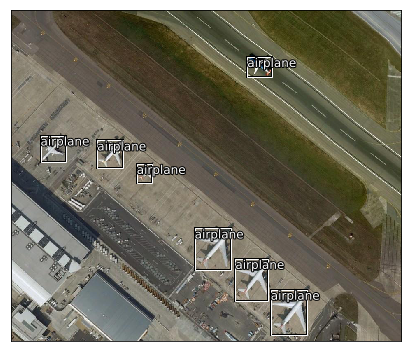

In [130]:
plot_img_bb(1)

# Old stuff

In [6]:
trn_j = json.load((PATH / 'pascal_train2007.json').open())

In [7]:
trn_j.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [8]:
trn_j['images'][:3], len(trn_j['images'])

([{'file_name': '000012.jpg', 'height': 333, 'width': 500, 'id': 12},
  {'file_name': '000017.jpg', 'height': 364, 'width': 480, 'id': 17},
  {'file_name': '000023.jpg', 'height': 500, 'width': 334, 'id': 23}],
 2501)

In [9]:
trn_ids = [o['id'] for o in trn_j['images']]

In [10]:
trn_fns = {o['id']: o['file_name'] for o in trn_j['images']}

In [11]:
trn_j['annotations'][:3], len(trn_j['annotations'])

([{'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]],
   'area': 34104,
   'iscrowd': 0,
   'image_id': 12,
   'bbox': [155, 96, 196, 174],
   'category_id': 7,
   'id': 1,
   'ignore': 0},
  {'segmentation': [[184, 61, 184, 199, 279, 199, 279, 61]],
   'area': 13110,
   'iscrowd': 0,
   'image_id': 17,
   'bbox': [184, 61, 95, 138],
   'category_id': 15,
   'id': 2,
   'ignore': 0},
  {'segmentation': [[89, 77, 89, 336, 403, 336, 403, 77]],
   'area': 81326,
   'iscrowd': 0,
   'image_id': 17,
   'bbox': [89, 77, 314, 259],
   'category_id': 13,
   'id': 3,
   'ignore': 0}],
 7844)

In [12]:
trn_bb = defaultdict(list)
for o in trn_j['annotations']:
    bb = o['bbox']
    bb = np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])
    trn_bb[o['image_id']].append((o['category_id'], bb))

In [13]:
len(trn_bb)

2501

In [14]:
trn_j['categories']

[{'supercategory': 'none', 'id': 1, 'name': 'aeroplane'},
 {'supercategory': 'none', 'id': 2, 'name': 'bicycle'},
 {'supercategory': 'none', 'id': 3, 'name': 'bird'},
 {'supercategory': 'none', 'id': 4, 'name': 'boat'},
 {'supercategory': 'none', 'id': 5, 'name': 'bottle'},
 {'supercategory': 'none', 'id': 6, 'name': 'bus'},
 {'supercategory': 'none', 'id': 7, 'name': 'car'},
 {'supercategory': 'none', 'id': 8, 'name': 'cat'},
 {'supercategory': 'none', 'id': 9, 'name': 'chair'},
 {'supercategory': 'none', 'id': 10, 'name': 'cow'},
 {'supercategory': 'none', 'id': 11, 'name': 'diningtable'},
 {'supercategory': 'none', 'id': 12, 'name': 'dog'},
 {'supercategory': 'none', 'id': 13, 'name': 'horse'},
 {'supercategory': 'none', 'id': 14, 'name': 'motorbike'},
 {'supercategory': 'none', 'id': 15, 'name': 'person'},
 {'supercategory': 'none', 'id': 16, 'name': 'pottedplant'},
 {'supercategory': 'none', 'id': 17, 'name': 'sheep'},
 {'supercategory': 'none', 'id': 18, 'name': 'sofa'},
 {'super

In [15]:
cats = {o['id']: o['name'] for o in trn_j['categories']}

### Plot the images with bounding boxes

In [60]:
from matplotlib import patches, patheffects

In [61]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1],a[2]-a[0]])

In [62]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

In [63]:
def plot_img_bb(img_id, bbs=trn_bb):
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    img = Image.open(IMG_PATH / trn_fns[img_id])
    ax.imshow(img)
    bbs = bbs[img_id]
    if not type(bbs) is list: bbs = [bbs]
    for o in bbs:
        cat, bb  = o[0], bb_hw(o[1])
        p = ax.add_patch(patches.Rectangle(bb[:2], *bb[-2:], fill=False, edgecolor='w'))
        draw_outline(p, 2)
        t = ax.text(bb[0], bb[1], cats[cat], color='w', fontsize=12, 
                    verticalalignment='top')
        draw_outline(t, 2)

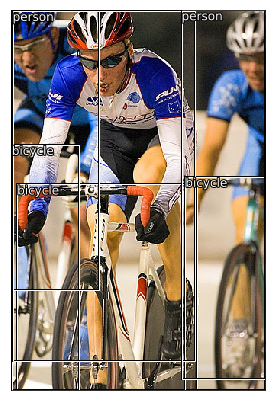

In [20]:
plot_img_bb(trn_ids[2])

## Largest object classifier

In [21]:
tmp = trn_bb[trn_ids[2]]

In [22]:
tmp

[(2, array([229,   8, 499, 244])),
 (2, array([219, 229, 499, 333])),
 (2, array([177,   1, 499,  89])),
 (15, array([  0,   1, 368, 116])),
 (15, array([  1,   2, 461, 242])),
 (15, array([  0, 224, 485, 333]))]

In [23]:
def get_largest(bbs):
    return sorted(bbs, key=lambda x: bb_hw(x[1])[2] * bb_hw(x[1])[3], reverse=True)[0]

In [24]:
trn_bb_lrg = {id: get_largest(trn_bb[id]) for id in trn_ids}

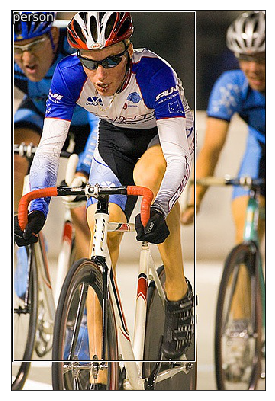

In [25]:
plot_img_bb(trn_ids[2], trn_bb_lrg)

In [26]:
lrg_df = pd.DataFrame(
    {'fn': [trn_fns[id] for id in trn_ids], 
     'cat': [cats[trn_bb_lrg[id][0]] for id in trn_ids]}, 
    columns = ['fn', 'cat'])

In [27]:
lrg_df.tail()

fn        cat
2496  009944.jpg  motorbike
2497  009945.jpg      sheep
2498  009949.jpg     person
2499  009959.jpg        car
2500  009961.jpg        dog

In [28]:
lrg_df.to_csv(PATH / 'lrg_df.csv', index=False)

### Pretrained model

In [29]:
f_model = resnet34
sz = 224
bs=64

In [30]:
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, crop_type=CropType.NO)

In [31]:
md = ImageClassifierData.from_csv(PATH, 'JPEGImages', PATH/ 'lrg_df.csv', tfms=tfms)

In [32]:
x, y=next(iter(md.val_dl))

In [33]:
x


( 0 , 0 ,.,.) = 
  3.9125e-01  4.3014e-01  4.8172e-01  ...   1.7518e-01  3.2367e-01  4.0783e-01
  5.1636e-01  4.4973e-01  5.9202e-01  ...   1.7386e-01  2.3164e-01  3.6722e-01
  5.4416e-01  5.7267e-01  7.0099e-01  ...   5.7682e-02  2.2320e-01  3.5455e-01
                 ...                   ⋱                   ...                
  1.4604e+00  1.5029e+00  1.5195e+00  ...   7.8030e-01  5.6716e-01 -6.3922e-01
  9.3739e-01  1.0210e+00  1.1599e+00  ...   1.1281e+00  1.0895e+00  4.5857e-01
  5.8584e-01  4.5245e-01  2.9605e-01  ...   1.0003e+00  9.2495e-01  8.2729e-01

( 0 , 1 ,.,.) = 
  2.4041e-01  3.1444e-01  4.1422e-01  ...   3.3162e-01  4.7052e-01  5.4764e-01
  3.9737e-01  4.2156e-01  5.7304e-01  ...   3.3887e-01  3.8799e-01  5.2038e-01
  5.2462e-01  5.8245e-01  6.7485e-01  ...   2.5190e-01  4.0003e-01  5.1502e-01
                 ...                   ⋱                   ...                
  1.4721e+00  1.5019e+00  1.5077e+00  ...   6.0917e-01  4.4337e-01 -7.3978e-01
  8.4169e-01  9.

In [64]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

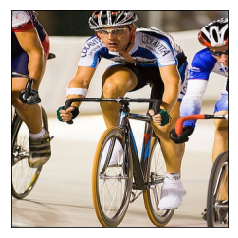

In [35]:
show_img(md.val_ds.denorm(to_np(x))[0]);

In [ ]:
learn = ConvLearner.pretrained(f_model, md, metrics=[accuracy])

In [36]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 224, 224]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 56, 56]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 56, 

In [235]:
learn.opt_fn = optim.Adam

In [236]:
lrf = learn.lr_find()

 91%|█████████ | 29/32 [00:20<00:02,  1.41it/s, loss=10.3]

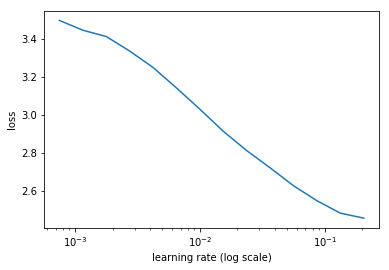

In [237]:
learn.sched.plot()

In [238]:
lr = 2e-2

In [241]:
learn.fit(lr, 1, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                 
    0      1.307141   0.864851   0.761569  


[0.8648515, 0.761568509042263]

In [246]:
lrs = np.array([lr/1000,lr/100,lr])

In [247]:
learn.freeze_to(-2)

 84%|████████▍ | 27/32 [00:44<00:08,  1.63s/it, loss=4.63] 

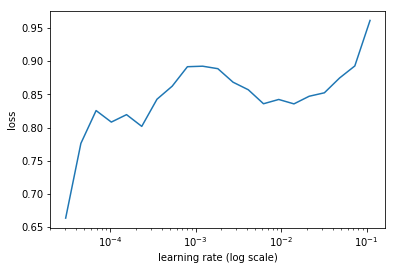

In [248]:
lrf=learn.lr_find(lrs/1000)
learn.sched.plot(1)

In [250]:
import tqdm

In [251]:
learn.fit(lrs/5, 1, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                  
    0      0.829375   0.744322   0.783504  


[0.74432206, 0.7835036069154739]

In [252]:
learn.unfreeze()

In [253]:
learn.fit(lrs/5, 1, cycle_len=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.621855   0.808581   0.782602  
    1      0.459543   0.731533   0.803035                  


[0.73153293, 0.8030348569154739]

In [254]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 224, 224]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', True),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', True),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 56, 56]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 56, 56

### Train from scratch

https://github.com/fastai/fastai/blob/master/courses/dl1/lesson7-cifar10.ipynb

In [34]:
class BnLayer(nn.Module):
    def __init__(self, ni, nf, stride=2, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=kernel_size, stride=stride,
                              bias=False, padding=1)
        self.a = nn.Parameter(torch.zeros(nf,1,1))
        self.m = nn.Parameter(torch.ones(nf,1,1))
        
    def forward(self, x):
        x = F.relu(self.conv(x))
        x_chan = x.transpose(0,1).contiguous().view(x.size(1), -1)
        if self.training:
            self.means = x_chan.mean(1)[:,None,None]
            self.stds  = x_chan.std (1)[:,None,None]
        return (x-self.means) / self.stds *self.m + self.a
class ResnetLayer(BnLayer):
    def forward(self, x): return x + super().forward(x)

In [61]:
class Resnet2(nn.Module):
    def __init__(self, layers, c, p=0.5):
        super().__init__()
        self.conv1 = BnLayer(3, 16, stride=1, kernel_size=7)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        self.drop = nn.Dropout(p)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.drop(x)
        return F.log_softmax(self.out(x), dim=-1)

In [62]:
my_learn = ConvLearner.from_model_data(Resnet2([16, 32, 64, 128, 256], 20, 0.2), md)

In [63]:
my_learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 224, 224]),
                           ('output_shape', [-1, 16, 220, 220]),
                           ('trainable', True),
                           ('nb_params', 2352)])),
             ('BnLayer-2',
              OrderedDict([('input_shape', [-1, 3, 224, 224]),
                           ('output_shape', [-1, 16, 220, 220]),
                           ('nb_params', 0)])),
             ('Conv2d-3',
              OrderedDict([('input_shape', [-1, 16, 220, 220]),
                           ('output_shape', [-1, 32, 110, 110]),
                           ('trainable', True),
                           ('nb_params', 4608)])),
             ('BnLayer-4',
              OrderedDict([('input_shape', [-1, 16, 220, 220]),
                           ('output_shape', [-1, 32, 110, 110]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 32, 110, 110

In [64]:
opt_fn = partial(optim.Adam)

In [65]:
my_learn.crit = F.nll_loss

In [66]:
my_learn.opt_fn = optim.Adam

In [67]:
my_learn.lr_find()

 78%|███████▊  | 25/32 [00:12<00:03,  2.06it/s, loss=8.78]

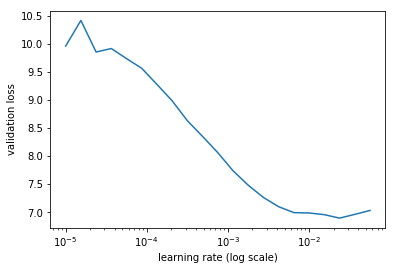

In [69]:
my_learn.sched.plot(0, 3)

In [70]:
lr = 1e-3
wd = 1e-6

In [71]:
my_learn.fit(lr, 2, cycle_len=2, wds=wd)

epoch      trn_loss   val_loss   accuracy                 
    0      4.614759   2.928633   0.246     
    1      3.533968   2.552393   0.254                    
    2      3.193371   2.619998   0.276                    
    3      2.885322   2.402542   0.296                    


[array([2.40254]), 0.2960000011920929]

In [72]:
lr = 1e-4

In [73]:
my_learn.fit(lr, 2, cycle_len=3, cycle_mult=2 , wds=wd)

epoch      trn_loss   val_loss   accuracy                 
    0      2.506186   2.494185   0.292     
    1      2.438319   2.346702   0.292                    
    2      2.399167   2.314342   0.318                    
    3      2.393828   2.428568   0.296                    
    4      2.370104   2.269139   0.302                    
    5      2.302039   2.269669   0.33                     
    6      2.270626   2.264354   0.304                    
    7      2.231869   2.453192   0.32                     
    8      2.184331   2.234639   0.322                    


[array([2.23464]), 0.3220000014305115]

In [83]:
x,y = next(iter(md.val_dl))
probs = F.softmax(predict_batch(my_learn.model, x), -1)
x,preds = to_np(x),to_np(probs)
preds = np.argmax(preds, -1)

In [84]:
preds

array([13, 14,  7, 14, 14,  6, 18, 17,  6,  2, 14,  6, 17, 14, 12,  0, 14, 14, 14, 14, 18,  6,  6,  6, 14,
        6,  6, 14, 14,  6,  6,  0, 18,  6,  6, 14, 14,  6,  0,  6, 14, 13,  6, 14,  3, 14, 14,  6, 14,  6,
       12, 14, 14, 14, 14,  7,  6,  0,  7,  3, 14, 14, 14, 14])

In [81]:
??draw_text

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


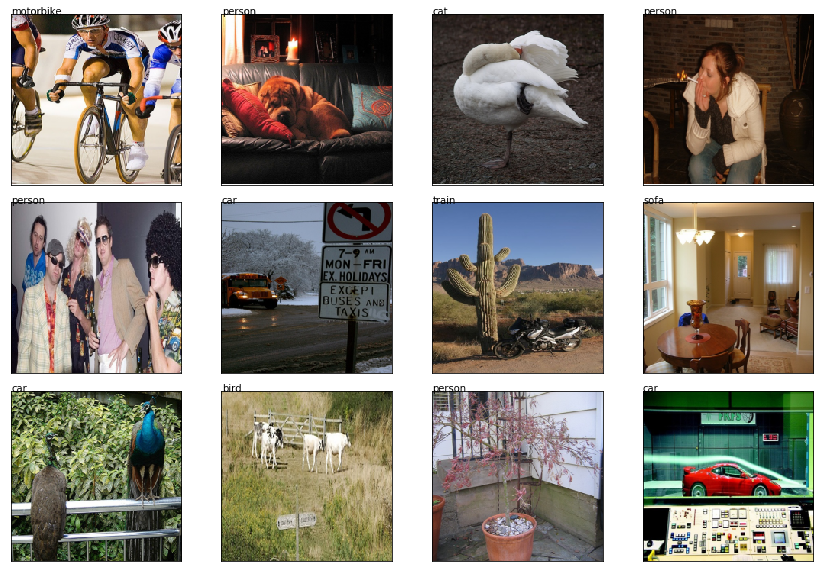

In [82]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(x)[i]
    b = md.classes[preds[i]]
    ax = show_img(ima, ax=ax)
    #draw_text(ax, (0,0), b)
    ax.text(0, 0, b)
plt.tight_layout()

## BBs only

In [28]:
bb_df = pd.DataFrame(
    {'fn': [trn_fns[id] for id in trn_ids], 
     'bb': [' '.join(str(b) for b in trn_bb_lrg[id][1]) for id in trn_ids]}, 
    columns = ['fn', 'bb'])

In [29]:
bb_df.to_csv(PATH / 'bb_df.csv', index=False)

In [30]:
bb_df.head()

fn              bb
0  000012.jpg  96 155 269 350
1  000017.jpg   77 89 335 402
2  000023.jpg     1 2 461 242
3  000026.jpg  124 89 211 336
4  000032.jpg  77 103 182 374

### Pretrained model

In [36]:
f_model=resnet34
sz=224
bs=64

In [37]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD)

In [38]:
md = ImageClassifierData.from_csv(PATH, 'JPEGImages', PATH/ 'bb_df.csv', tfms=tfms, continuous=True)

In [93]:
head_reg4 = nn.Sequential(Flatten(), nn.Linear(25088, 4))

In [94]:
learn = ConvLearner.pretrained(f_model, md, custom_head=head_reg4)
learn.opt_fn = optim.Adam
learn.crit = nn.L1Loss()

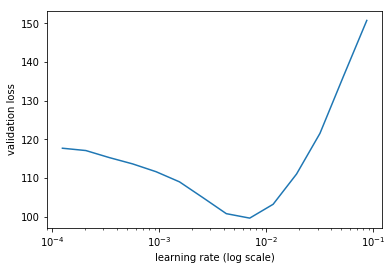

In [95]:
learn.lr_find(1e-5,100)
learn.sched.plot(5)

In [96]:
lr = 2e-3

In [97]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                            
    0      49.171924  35.071456 
    1      36.919292  27.917541                           
    2      30.763059  27.289077                           


[array([27.28908])]

In [98]:
lrs = np.array([lr/100,lr/10,lr])

In [99]:
learn.freeze_to(-2)

In [101]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                            
    0      25.826559  23.0386   
    1      22.262047  22.213562                           
    2      18.201179  20.892107                           


[array([20.89211])]

In [102]:
learn.freeze_to(-3)

In [103]:
learn.fit(lrs, 1, cycle_len=2)

epoch      trn_loss   val_loss                            
    0      16.015375  21.804226 
    1      14.465886  20.717461                           


[array([20.71746])]

In [104]:
x,y = next(iter(md.val_dl))
learn.model.eval()
preds = to_np(learn.model(VV(x)))

In [106]:
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


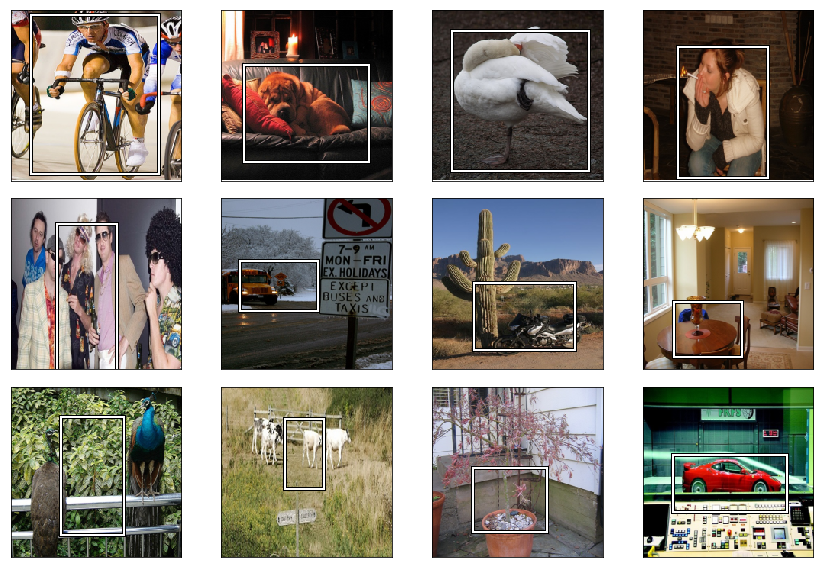

In [107]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(to_np(x))[i]
    b = bb_hw(preds[i])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)
plt.tight_layout()

### From scratch

In [47]:
class Resnet2_reg(nn.Module):
    def __init__(self, layers, c, p=0.5):
        super().__init__()
        self.conv1 = BnLayer(3, 16, stride=1, kernel_size=7)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(256*7*7, c)
        self.drop = nn.Dropout(p)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = x.view(x.size(0), -1)
        #x = nn.Linear(x.size(0), 4)(x)
        return self.out(x)

In [48]:
my_learn = ConvLearner.from_model_data(Resnet2_reg([16, 32, 64, 128, 256, 256], 4, 0.2), md)

In [49]:
my_learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 224, 224]),
                           ('output_shape', [-1, 16, 220, 220]),
                           ('trainable', True),
                           ('nb_params', 2352)])),
             ('BnLayer-2',
              OrderedDict([('input_shape', [-1, 3, 224, 224]),
                           ('output_shape', [-1, 16, 220, 220]),
                           ('nb_params', 0)])),
             ('Conv2d-3',
              OrderedDict([('input_shape', [-1, 16, 220, 220]),
                           ('output_shape', [-1, 32, 110, 110]),
                           ('trainable', True),
                           ('nb_params', 4608)])),
             ('BnLayer-4',
              OrderedDict([('input_shape', [-1, 16, 220, 220]),
                           ('output_shape', [-1, 32, 110, 110]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 32, 110, 110

In [50]:
my_learn.opt_fn = optim.Adam
my_learn.crit = nn.L1Loss()

In [51]:
my_learn.lr_find(1e-5,100)

 75%|███████▌  | 24/32 [00:11<00:03,  2.01it/s, loss=110] 

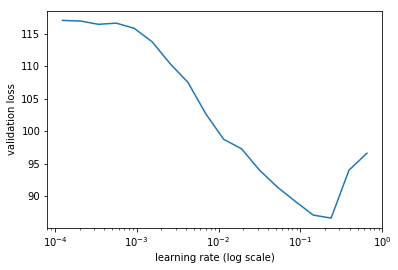

In [52]:
my_learn.sched.plot(5, 0)

In [53]:
lr = 2e-3

In [54]:
my_learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                            
    0      47.288696  35.157158 
    1      39.073773  33.53347                            
    2      35.363925  32.831224                           


[array([32.83122])]

In [55]:
lr = 1e-3

In [56]:
my_learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                            
    0      32.971272  32.071664 
    1      32.259794  31.013573                           
    2      31.094216  30.546807                           


[array([30.54681])]

In [57]:
x,y = next(iter(md.val_dl))
my_learn.model.eval()
preds = to_np(my_learn.model(VV(x)))

In [58]:
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


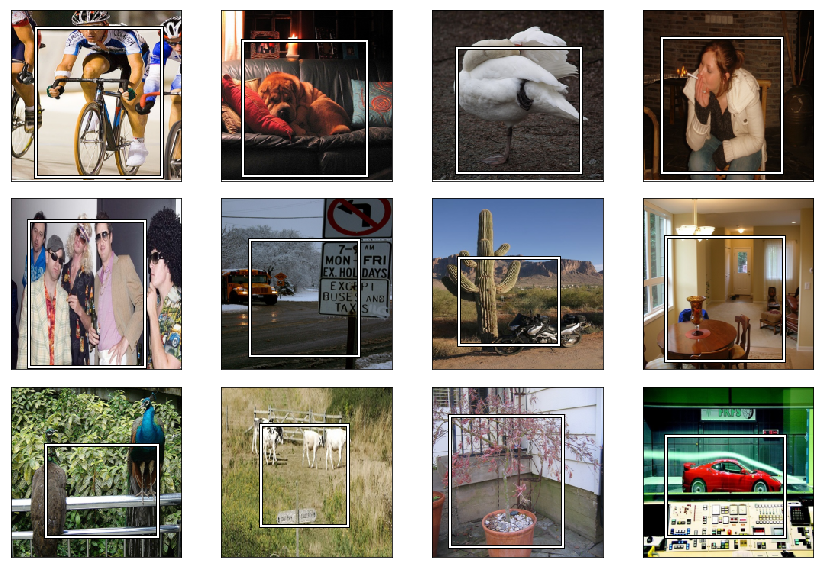

In [65]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(to_np(x))[i]
    b = bb_hw(preds[i])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)
plt.tight_layout()

In [67]:
md.val_y.shape, md.trn_y.shape

((500, 4), (2001, 4))